# Курсовая

#### Требования к курсовому:

Нужно будет оформить ноутбук с основными этапами:

- подготовка данных
- анализ
- визуализация
- обработка выбросов
- обработка пропусков
- генерация фичей
- обучение модели
- проверка качества модели

Так же надо отправить файл с предсказаниями на kaggle и на private leaderboard получить больше 0.6

Данные для курсового можно брать отсюда https://www.kaggle.com/t/b4c9382d4f934176af9fe860b1976528 (вкладка data)

За шаблон оформления курсовой можно взять ноутбук, который будем разбирать на уроке 10: https://www.kaggle.com/julichitai/baseline

### Что обязательно стоит попробовать:

- Тщательный анализ данных
- Поиск странных значений
- Предобработка данных
- Генерация разнообразных признаков
- Разные модели и их разные гиперпараметры

### Что не стоит пробовать:

- Кластеризация
- Модели понижения размерности

## Подключение необходимых библиотек

In [1]:
import random
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from random import randint
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 12})  # размер шрифта на графиках

## Полезные функции

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# Функция для создания дополнительных признаков при обработка NAN значений
def add_features_nan(feature_name, df):
    df_fill = df.copy()
    df_fill[feature_name + '_nan'] = 0
    df_fill.loc[df[feature_name].isna(), feature_name + '_nan'] = 1     
    return df_fill

In [4]:
# Функция для заполнения NAN значений медианой по признаку
def fill_nan(feature_name, df):
    df_fill = df.copy()
    median = df_fill[feature_name].median()
    df_fill[feature_name] = df_fill[feature_name].fillna(median)
    return df_fill

In [5]:
# Функция для замены категориальных признаков типа {А/В} на {0/1}
def fill_category(feature_name, df):
    df_fill = df.copy()
    df_fill[feature_name + '_ctg'] = df_fill[feature_name].replace({'A': 0, 'B': 1})
    return df_fill

In [6]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2_score(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2_score(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [7]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [X['Floor'].min(), 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [X['HouseYear'].min(), 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

## Чтение данных

In [8]:
DATA_TRAIN_PATH = './data/real-estate-price-prediction-moscow/train.csv'
DATA_TEST_PATH = './data/real-estate-price-prediction-moscow/test.csv'

In [9]:
# Читаем ТРЕНИРОВОЧНЫЙ массив данных
df_train = pd.read_csv(DATA_TRAIN_PATH)
df_train.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [11]:
# Оптимизируем память отводимую на массивы
print("--------------------df_train memory-------------------------------")
reduce_mem_usage(df_train)

--------------------df_train memory-------------------------------
Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [13]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


## <span style="color:orange"> Визуализация данных </span>

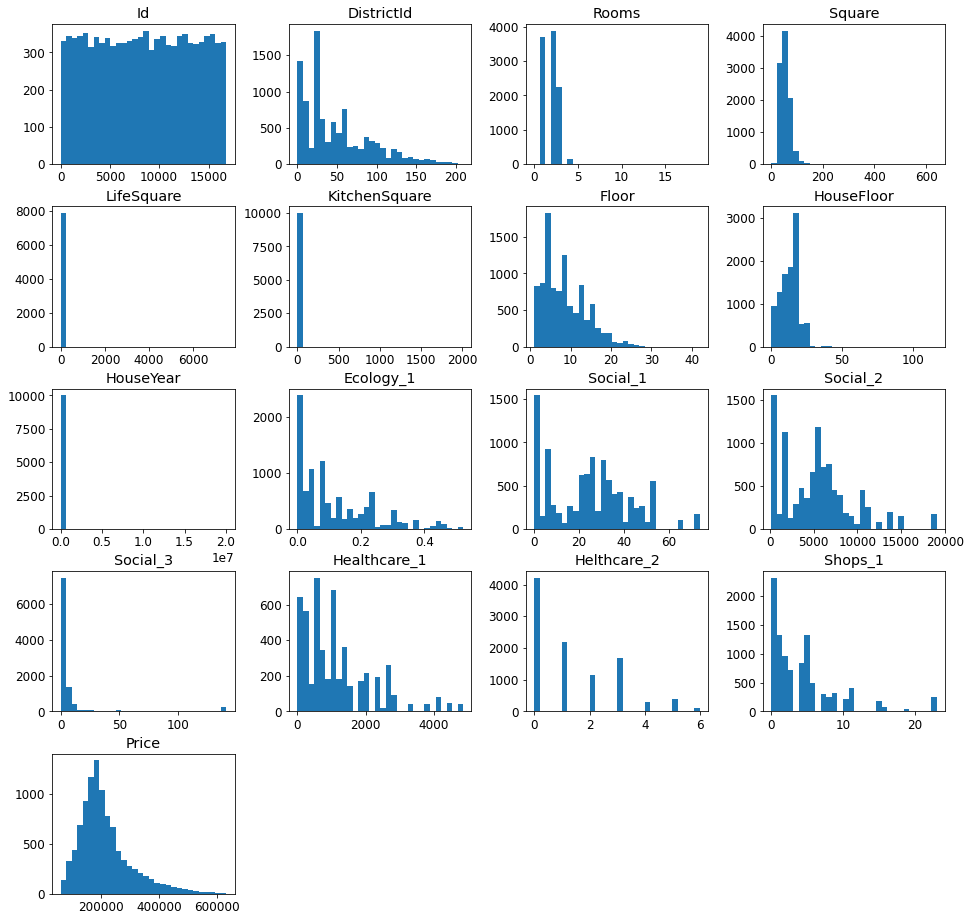

In [14]:
df_num_features = df_train.select_dtypes(include=[np.number])
df_num_features.hist(figsize=(16,16), bins=30, grid=False);

##### <span style="color:red"> Вывод: </span>
1) Выброс явно присутствует в году постройки дома, поскольку крайнее значение аж 10^7

2) Также выбросы есть и в Жилых площадях, площади кухни и общей площади. 
    
    а) Square < LifeSquare + KithenSquare
    
    б) Очень большая площать KithenSquare и LifeSquare
    
3) В признаке Rooms есть вываливающиеся значения + кол-во комнат = 0

4) Аналогично, есть выбросы и в признаке HouseFloor

5) Есть ошибка когда Floor > HouseFloor

6) id, DistrictId - с ними надо что-то сделать

## <span style="color:green"> Категориальные признаки </span>

In [15]:
df_train.select_dtypes('category').head(2)

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B


In [16]:
df_train = fill_category('Ecology_2', df_train)
df_train = fill_category('Ecology_3', df_train)
df_train = fill_category('Shops_2', df_train)
df_train.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_ctg,Ecology_3_ctg,Shops_2_ctg
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,3097,0,NaN,0,0,B,305018.875000,1,1,1
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,6207,1,1183.0,1,0,B,177734.546875,1,1,1
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,5261,0,240.0,3,1,B,282078.718750,1,1,1
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,...,264,0,NaN,0,1,B,168106.000000,1,1,1


In [17]:
df_train[['Ecology_2', 'Ecology_3', 'Shops_2', 'Ecology_2_ctg', 'Ecology_3_ctg', 'Shops_2_ctg']].tail(4)

,Ecology_2,Ecology_3,Shops_2,Ecology_2_ctg,Ecology_3_ctg,Shops_2_ctg
9996,B,B,A,1,1,0
9997,B,B,B,1,1,1
9998,B,B,B,1,1,1
9999,B,B,B,1,1,1


##  <span style="color:blue">Обработка выбросов и заполнение пропусков</span>

### <span style="color:blue"> HouseYear </span>

In [18]:
df_train[df_train['HouseYear'] > 2021]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_ctg,Ecology_3_ctg,Shops_2_ctg
8828,11607,147,2.0,44.791836,28.360394,5.0,4,9.0,4968,0.319809,...,4756,16,2857.0,5,8,B,243028.609375,1,1,1
9163,10814,109,1.0,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,...,6141,10,262.0,3,6,B,254084.531250,1,1,1


In [19]:
# Вариант 1 - ручная работа)
#df_train.loc[df_train.index == 8828, 'HouseYear'] = 1968
#df_train.loc[df_train.index == 9163, 'HouseYear'] = 2011

In [20]:
# Вариант 2 - автомат)
df_train.loc[df_train['HouseYear'] > 2021, 'HouseYear'] = df_train['HouseYear'].median()

### <span style="color:blue"> Rooms </span>

In [21]:
groupby = df_train.groupby('Rooms')
rooms_stat = pd.DataFrame({'Num': groupby['Rooms'].count(),
                           'Square': groupby['Square'].mean()})
rooms_stat

,Num,Square
Rooms,,
0.0,8,81.620361
1.0,3705,41.323277
2.0,3880,56.788212
3.0,2235,76.903236
4.0,150,98.377541
5.0,18,122.614944
6.0,1,59.414333
10.0,2,59.964119
19.0,1,42.006046


 <span style="color:red"> Явно выбросы в количестве комнат Rooms = [0, 10, 19] + [6] - странно что в 6-ти комнатной квартире площадь меньше чем в 5-ти, ... </span>

In [22]:
# Создаем переменную dummies 
df_train['Rooms_lim'] = 0
df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] >= 6),'Rooms_lim'] = 1

In [23]:
# Вариант 1 - обработка выбросов по общей площади (правда ручная обработка)
df_train.loc[df_train['Rooms'] == 19 , 'Rooms'] = 1
df_train.loc[df_train['Rooms'].isin([6, 10]) , 'Rooms'] = 2
df_train.loc[df_train['Rooms'] == 0 , 'Rooms'] = 3

In [24]:
# Вариант 2 - обработать все разом просто по средней
#df_train.loc[df_train['Rooms'].isin([0, 6, 10, 19]) , 'Rooms'] = df_train['Rooms'].median()

### <span style="color:blue"> HouseFoor and Floor </span>

#### Обрабатываем выбросы по HouseFloor

In [25]:
df_train['HouseFloor'].value_counts().sort_index().head(5)

0.0    269
1.0    497
2.0     48
3.0    127
4.0    134
Name: HouseFloor, dtype: int64

In [26]:
df_train['HouseFloor'].value_counts().sort_index().tail(5)

45.0     1
47.0     1
48.0     2
99.0     2
117.0    1
Name: HouseFloor, dtype: int64

<span style="color:red"> Выбросы дома с HouseFloor = [0] - такого не бывает</span>

In [27]:
# Создаем dummies для случая когда ['HouseFloor'] == 0
df_train['HouseFloor_inf'] = 0
df_train.loc[df_train['HouseFloor'] == 0,'HouseFloor_inf'] = 1

In [28]:
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = round(df_train['HouseFloor'].median())

#### Обрабатываем выбросы по Floor > HouseFloor

In [29]:
# Создаем dummies для случая когда 'HouseFloor' < 'Floor'
df_train['Floor_lim'] = 0
df_train.loc[df_train['HouseFloor'] < df_train['Floor'],'Floor_lim'] = 1

In [30]:
# Вариант 1 - Заменить все этажи в признаке Floor на значение HouseFloor, если Floor > HouseFloor
# df_train.loc[df_train['HouseFloor'] < df_train['Floor'], 'Floor'] =\
# df_train.loc[df_train['HouseFloor'] < df_train['Floor'], 'HouseFloor']

In [31]:
# Вариант 2 - Заменить все этажи в признаке Floor на значение random до значения HouseFloor, если Floor > HouseFloor
for i in df_train.loc[df_train['HouseFloor'] < df_train['Floor']].index:
    df_train.loc[i, 'Floor'] = int(random.randint(1, df_train.loc[i]['HouseFloor']))

### <span style="color:blue"> Square, LifeSquare, KitchenSquare </span>

#### <span style="color:blue"> KitchenSquare </span>

In [32]:
groupby = df_train.groupby('KitchenSquare')
kitchen_stat = pd.DataFrame({'Num': groupby['KitchenSquare'].count(),
                           'Rooms': groupby['Rooms'].mean(),
                           'Square': groupby['Square'].mean(), 
                           'LifeSquare': groupby['LifeSquare'].mean()})
kitchen_stat.head(5)

,Num,Rooms,Square,LifeSquare
KitchenSquare,,,,
0.0,697,1.810617,60.133381,54.811466
1.0,2460,1.771951,60.216042,53.727676
2.0,4,1.250000,28.318375,18.813358
3.0,22,1.409091,32.697697,17.614101
4.0,39,1.743590,43.307240,29.644098


In [33]:
df_rooms = df_train.groupby('Rooms', as_index=False).median()
df_rooms[['Rooms', 'Square', 'KitchenSquare', 'LifeSquare']]

,Rooms,Square,KitchenSquare,LifeSquare
0,1.0,40.408249,6.0,21.663952
1,2.0,55.851315,6.0,32.554848
2,3.0,77.413643,7.0,46.961452
3,4.0,98.668060,9.0,64.946548
4,5.0,116.084862,9.0,80.458908


In [34]:
# $ Заполняем площадь кухни KitchenSquare (там где < 3 и > quantile(0.99)) медианным значением внутри группы по количеству комнат
for i in df_train.loc[df_train['KitchenSquare'] < 3].index:
    df_train.loc[i, 'KitchenSquare'] = df_rooms.loc[int(df_train.loc[1]['Rooms'])]['KitchenSquare']

for i in df_train.loc[df_train['KitchenSquare'] > df_train['KitchenSquare'].quantile(0.99)].index:
    df_train.loc[i, 'KitchenSquare'] = df_rooms.loc[int(df_train.loc[1]['Rooms'])]['KitchenSquare']

#### <span style="color:blue"> LifeSquare </span>

In [35]:
# Создаем dummies признак
df_train = add_features_nan('LifeSquare', df_train)

In [36]:
# Заполняем пропуски в LifeSquare средним значением по количеству комнат
mask = df_train['LifeSquare'].isna()
for i in df_train.loc[mask].index:
    df_train.loc[i, 'LifeSquare'] = df_rooms.loc[int(df_train.loc[1]['Rooms'])]['LifeSquare']

In [37]:
# Вариант 2 - Заполняем медианой 
#df_train = fill_nan('LifeSquare', df_train)

In [38]:
# Заменяем значение LifeSquare которое меньше установленного норматива в РФ ~6 на значение 6 (для данное выборки quantile(0.02))
df_train['LifeSquare_inf'] = 0
mask = (df_train['LifeSquare'] < df_train['LifeSquare'].quantile(0.02))
df_train.loc[mask, 'LifeSquare_inf'] = 1
df_train.loc[mask, 'LifeSquare'] = df_train['LifeSquare'].quantile(0.02)

#### <span style="color:blue"> Healthcare_1 </span>

In [39]:
#df_train = add_features_nan('Healthcare_1', df_train)

In [40]:
# Вариант 1 - Заполняем значения NAN медианным значением признака Healthcare_1
#df_train = fill_nan('Healthcare_1', df_train)

In [41]:
# Вариант 2 - dropаем признак (работает лучше чем вариант 1)
df_train.drop('Healthcare_1', axis=1, inplace=True)

In [42]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Id              10000 non-null  int16   
 1   DistrictId      10000 non-null  int16   
 2   Rooms           10000 non-null  float32 
 3   Square          10000 non-null  float32 
 4   LifeSquare      10000 non-null  float32 
 5   KitchenSquare   10000 non-null  float32 
 6   Floor           10000 non-null  int8    
 7   HouseFloor      10000 non-null  float32 
 8   HouseYear       10000 non-null  int32   
 9   Ecology_1       10000 non-null  float32 
 10  Ecology_2       10000 non-null  category
 11  Ecology_3       10000 non-null  category
 12  Social_1        10000 non-null  int8    
 13  Social_2        10000 non-null  int16   
 14  Social_3        10000 non-null  int16   
 15  Helthcare_2     10000 non-null  int8    
 16  Shops_1         10000 non-null  int8    
 17  Shops_2      

## <span style="color:purple"> Конструирование признаков </span>

###  <span style="color:purple"> Вариант с урока </span>

In [43]:
district_size = df_train['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

In [44]:
df_train = df_train.merge(district_size, on='DistrictId', how='left')

In [45]:
df_train['IsDistrictLarge'] = (df_train['DistrictSize'] > 100).astype(int)

In [46]:
med_price_by_district = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})
med_price_by_district

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146574.015625
4,1,2.0,202706.093750
...,...,...,...
662,202,3.0,286215.875000
663,205,1.0,220501.562500
664,207,3.0,426186.406250
665,208,2.0,431137.625000


In [47]:
df_train = df_train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

In [48]:
bins = [df_train['Floor'].min(), 3, 5, 9, 15, df_train['Floor'].max()]
pd.cut(df_train['Floor'], bins=bins, labels=False)

0       1.0
1       2.0
2       0.0
3       3.0
4       4.0
       ... 
9995    0.0
9996    3.0
9997    0.0
9998    0.0
9999    2.0
Name: Floor, Length: 10000, dtype: float64

In [49]:
bins = [df_train['Floor'].min(), 3, 5, 9, 15, df_train['Floor'].max()]
pd.cut(df_train['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (1, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (1, 3]
9996     (9, 15]
9997      (1, 3]
9998      (1, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(1, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [50]:
df_train = year_to_cat(df_train)
df_train = floor_to_cat(df_train)
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_lim,HouseFloor_inf,Floor_lim,LifeSquare_nan,LifeSquare_inf,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027313,32.554848,10.0,4,10.0,2014,0.075424,...,0,0,0,1,0,851,1,213688.718750,6,2
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,0,0,0,0,0,78,0,146032.828125,3,3
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,0,0,0,0,652,1,244005.281250,4,1
3,2352,1,1.0,40.409908,32.554848,6.0,10,22.0,1977,0.007122,...,0,0,0,1,0,652,1,146574.015625,3,4
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,0,0,0,0,0,89,0,201584.437500,3,5


In [51]:
med_price_by_floor_year = df_train.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,357700.71875
1,1,2,324303.81250
2,1,3,429090.87500
3,1,4,274992.46875
4,2,1,467230.53125


In [52]:
df_train = df_train.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_inf,Floor_lim,LifeSquare_nan,LifeSquare_inf,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027313,32.554848,10.0,4,10.0,2014,0.075424,...,0,0,1,0,851,1,213688.718750,6,2,166682.906250
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,0,0,0,0,78,0,146032.828125,3,3,192837.906250
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,0,0,0,652,1,244005.281250,4,1,209125.875000
3,2352,1,1.0,40.409908,32.554848,6.0,10,22.0,1977,0.007122,...,0,0,1,0,652,1,146574.015625,3,4,183622.421875
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,0,0,0,0,89,0,201584.437500,3,5,173955.562500


###  <span style="color:purple"> Учет социальных факторов </span>

In [53]:
df_train[['Social_1', 'Social_2', 'Social_3', 'Price']]

,Social_1,Social_2,Social_3,Price
0,11,3097,0,305018.875000
1,30,6207,1,177734.546875
2,33,5261,0,282078.718750
3,1,264,0,168106.000000
4,33,8667,2,343995.093750
...,...,...,...,...
9995,52,10311,6,119367.453125
9996,2,629,1,199715.156250
9997,20,4386,14,165953.906250
9998,47,8004,3,171842.406250


In [54]:
social_price = df_train.groupby(['Social_1', 'Social_2', 'Social_3'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'Social_environment_Prise'})
social_price

,Social_1,Social_2,Social_3,Social_environment_Prise
0,0,168,0,94177.890625
1,0,186,0,196538.375000
2,1,264,0,183882.812500
3,1,290,0,88676.085938
4,1,388,0,90431.000000
...,...,...,...,...
137,52,11217,1,243332.046875
138,53,13670,4,272731.187500
139,53,14892,4,183348.000000
140,66,10573,1,183792.890625


In [55]:
df_train = df_train.merge(social_price, on=['Social_1', 'Social_2', 'Social_3'], how='left')

# <span style="color:red"> Классы</span>

In [56]:
class DataSmoothing:

    def __init__(self):
        self.medians = None
        self.kitchen_square_quantile = None
        self.life_square_quantile = None
        
    def fit(self, X):
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.99)
        self.life_square_quantile = X['LifeSquare'].quantile(0.02)
    
    def add_features_nan(self, feature_name, X):
        df_fill = X.copy()
        df_fill[feature_name + '_nan'] = 0
        df_fill.loc[X[feature_name].isna(), feature_name + '_nan'] = 1     
        return df_fill

    def fill_category(self, feature_name, X):
        df_fill = X.copy()
        df_fill[feature_name + '_ctg'] = df_fill[feature_name].replace({'A': 0, 'B': 1})
        return df_fill
    
    def transform(self, X):
        #---------Ecology_1_2 and Shops_2----------------------------------
        X = self.fill_category('Ecology_2', X)
        X = self.fill_category('Ecology_3', X)
        X = self.fill_category('Shops_2', X)
        
        if 'Shops_2' in X.columns:
            X.drop('Shops_2', axis=1, inplace=True)
        if 'Ecology_2' in X.columns:
            X.drop('Ecology_2', axis=1, inplace=True)
        if 'Ecology_3' in X.columns:
            X.drop('Ecology_3', axis=1, inplace=True)
        #-------------------------------------------------------------------
        
        #----------Rooms----------------------------------------------------
        X['Rooms_lim'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6),'Rooms_lim'] = 1

        X.loc[X['Rooms'] == 19 , 'Rooms'] = 1
        X.loc[X['Rooms'].isin([6, 10]) , 'Rooms'] = 2
        X.loc[X['Rooms'] == 0 , 'Rooms'] = 3
        #-------------------------------------------------------------------
        
        #---------KitchenSquare---------------------------------------------
        groupby = X.groupby('KitchenSquare')
        kitchen_stat = pd.DataFrame({'Num': groupby['KitchenSquare'].count(),
                           'Rooms': groupby['Rooms'].mean(),
                           'Square': groupby['Square'].mean(), 
                           'LifeSquare': groupby['LifeSquare'].mean()})
        df_rooms = X.groupby('Rooms', as_index=False).median()
        
        for i in X.loc[X['KitchenSquare'] < 3].index:
            X.loc[i, 'KitchenSquare'] = df_rooms.loc[int(X.loc[1]['Rooms'])]['KitchenSquare']

        for i in X.loc[X['KitchenSquare'] > self.kitchen_square_quantile].index:
            X.loc[i, 'KitchenSquare'] = df_rooms.loc[int(X.loc[1]['Rooms'])]['KitchenSquare']
        #--------------------------------------------------------------------  
        
        #-------LifeSquare---------------------------------------------------
        X = self.add_features_nan('LifeSquare', X)
        mask = X['LifeSquare'].isna()
        for i in X.loc[mask].index:
            X.loc[i, 'LifeSquare'] = df_rooms.loc[int(X.loc[1]['Rooms'])]['LifeSquare']
        
        X['LifeSquare_inf'] = 0
        mask = (X['LifeSquare'] < self.life_square_quantile)
        X.loc[mask, 'LifeSquare_inf'] = 1
        X.loc[mask, 'LifeSquare'] = self.life_square_quantile
        #--------------------------------------------------------------------
        
        #-------HouseFloor, Floor--------------------------------------------
        X['HouseFloor_inf'] = 0
        X.loc[X['HouseFloor'] == 0,'HouseFloor_inf'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = round(self.medians['HouseFloor'])
        
        X['Floor_lim'] = 0
        X.loc[X['HouseFloor'] < X['Floor'],'Floor_lim'] = 1
        
        for i in X.loc[X['HouseFloor'] < X['Floor']].index:
            X.loc[i, 'Floor'] = int(random.randint(1, X.loc[i]['HouseFloor']))
        #--------------------------------------------------------------------
        
        #-----HouseYear------------------------------------------------------
        X.loc[X['HouseYear'] > 2021, 'HouseYear'] = self.medians['HouseYear']
        #--------------------------------------------------------------------
        
        #-------Healthcare_1-------------------------------------------------
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
        #--------------------------------------------------------------------   
        
        return X

In [57]:
class FeatureMaker():
    
    def __init__(self):
        self.DistrictId_counts = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        self.social_price = None
        
    def fit(self, X, y=None):
        X = X.copy()
        #----------DistrictID-------------------------------------------------
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        #---------------------------------------------------------------------
        
        #----------District, Rooms--------------------------------------------
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
        #--------------------------------------------------------------------    
        
        
        #----------Social, Price--------------------------------------------
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.social_price = df.groupby(['Social_1', 'Social_2', 'Social_3'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'Social_environment_Prise'})
            
            self.social_price_median = self.social_price['Social_environment_Prise'].median()
        #--------------------------------------------------------------------    
          
        #-------Floor, Year--------------------------------------------------
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
       #-------------------------------------------------------------------- 
    
    def transform(self, X):      
        X = X.merge(self.district_size, on='DistrictId', how='left')  
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        X['DistrictSize'].fillna(5, inplace=True)
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        if self.social_price is not None:
            X = X.merge(self.social_price, on=['Social_1', 'Social_2', 'Social_3'], how='left')
            X['Social_environment_Prise'].fillna(self.social_price_median, inplace=True)
        return X
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['year_cat'].fillna(-1, inplace=True)
        return X

# ОБУЧЕНИЕ

In [58]:
df_train = pd.read_csv(DATA_TRAIN_PATH)
df_test = pd.read_csv(DATA_TEST_PATH)

In [59]:
X = df_train.drop(columns='Price')
y = df_train['Price']

In [60]:
smooth = DataSmoothing()
smooth.fit(X)

X = smooth.transform(X)
df_test = smooth.transform(df_test)

In [61]:
featmaker = FeatureMaker()
featmaker.fit(X, y)

X = featmaker.transform(X)
df_test = featmaker.transform(df_test)

### Для экспериментов с различными признаками

In [62]:
feature_names = X.columns.tolist()
feature_names.remove('Id')
feature_names.remove('DistrictId')
# feature_names.remove('year_cat')
# feature_names.remove('floor_cat')
# feature_names.remove('MedPriceByDistrict')
# feature_names.remove('DistrictSize')
# feature_names.remove('new_district')
# feature_names.remove('IsDistrictLarge')
# feature_names.remove('MedPriceByFloorYear')
# feature_names.remove('Social_environment_Prise')

In [63]:
X = X[feature_names]
df_test = df_test[feature_names]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.33, shuffle=True)

### Случайный лес

In [65]:
rftree = RandomForestRegressor(random_state=42, criterion='mse')
rftree.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [66]:
y_pred = rftree.predict(X_test)
y_pred_train = rftree.predict(X_train)
sc = r2_score(y_test, y_pred)
sc1 = r2_score(y_train, y_pred_train)
print('r2_scr_test = ', sc, '\nr2_scr_train = ', 
      sc1)

r2_scr_test =  0.7403494296164896 
r2_scr_train =  0.966649039120805


Train R2:	0.967
Test R2:	0.74


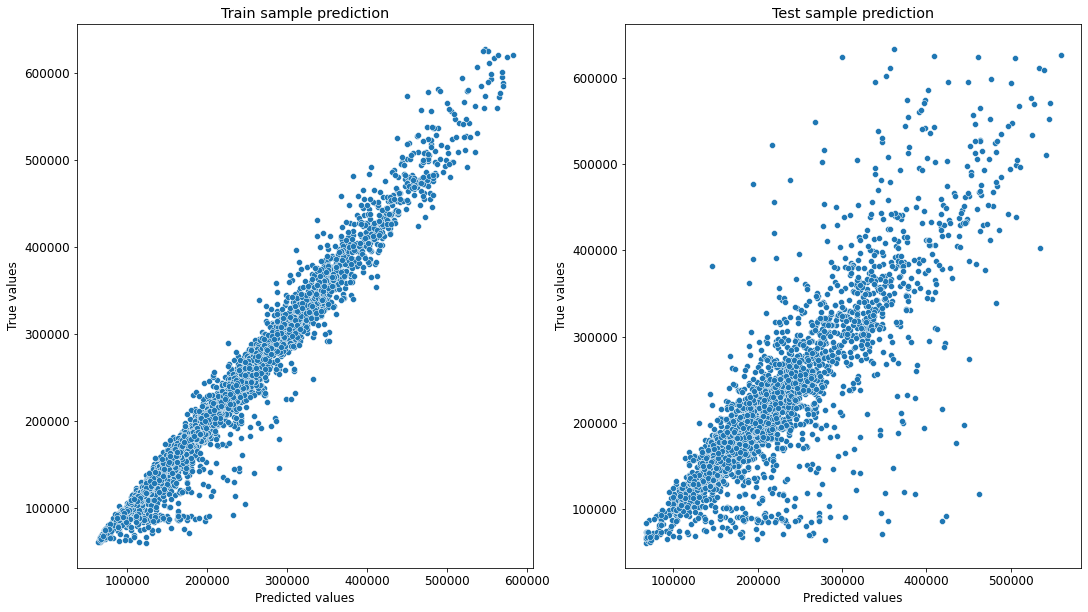

In [67]:
evaluate_preds(y_train, y_pred_train, y_test, y_pred)

#####  <span style="color:black"> Наблюдается некоторое переобучение на тренировочном датасете. Причем при введении признаков завязанных на Price точность повышается, но и переобучение усиляется. Отмечу, что признак MedPriceByDistrict дает существенную прибавку к точности. Если его убрать, то следующим по важности вылезает Social_environment_Prise, что в принципе подтверждает тезис выше.</span>

In [68]:
cv_score = cross_val_score(rftree, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score

array([0.74895438, 0.72075544, 0.74961175])

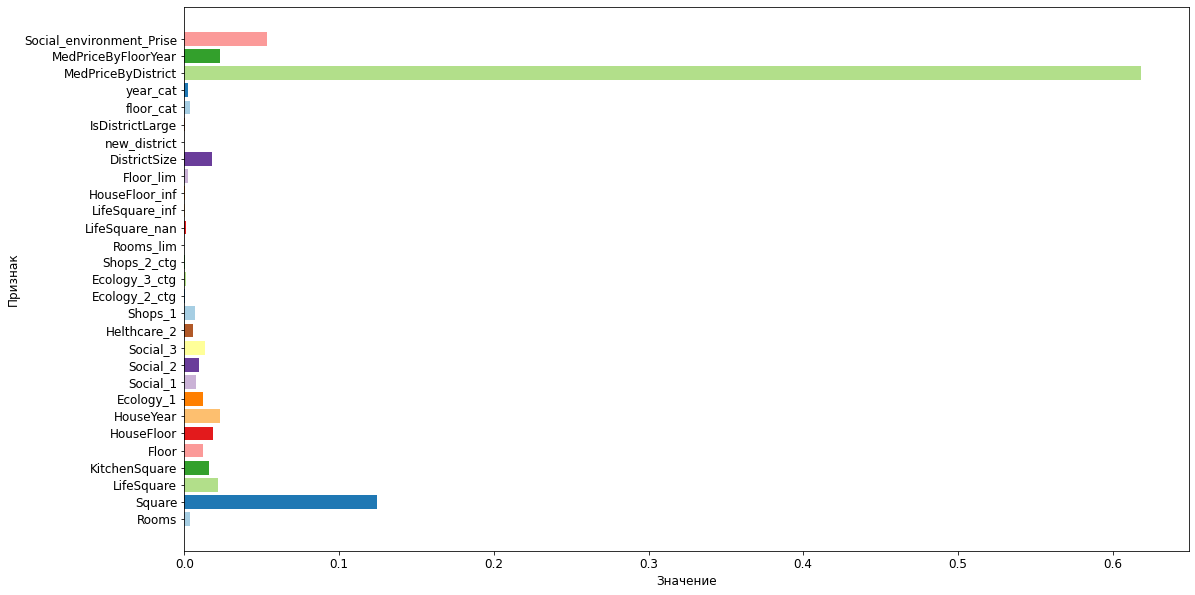

In [69]:
plt.figure(figsize=(18,10))
plt.barh(range(X.shape[1]), rftree.feature_importances_, 
         align = 'center', color = sns.color_palette("Paired"))
plt.yticks(np.arange(X.shape[1]), feature_names)
plt.xlabel('Значение')
plt.ylabel('Признак')
plt.show()

### Градиентный бустинг

In [70]:
gbtree = GradientBoostingRegressor(random_state=42, criterion='mse', alpha = 0.1)
gbtree.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.1, criterion='mse', random_state=42)

In [71]:
y_pred = gbtree.predict(X_test)
y_pred_train = gbtree.predict(X_train)

sc = r2_score(y_test, y_pred)
sc1 = r2_score(y_train, y_pred_train)
print('r2_scr_test = ', sc, '\nr2_scr_train = ', 
      sc1)

r2_scr_test =  0.746607902357846 
r2_scr_train =  0.8029806962142443


Train R2:	0.803
Test R2:	0.747


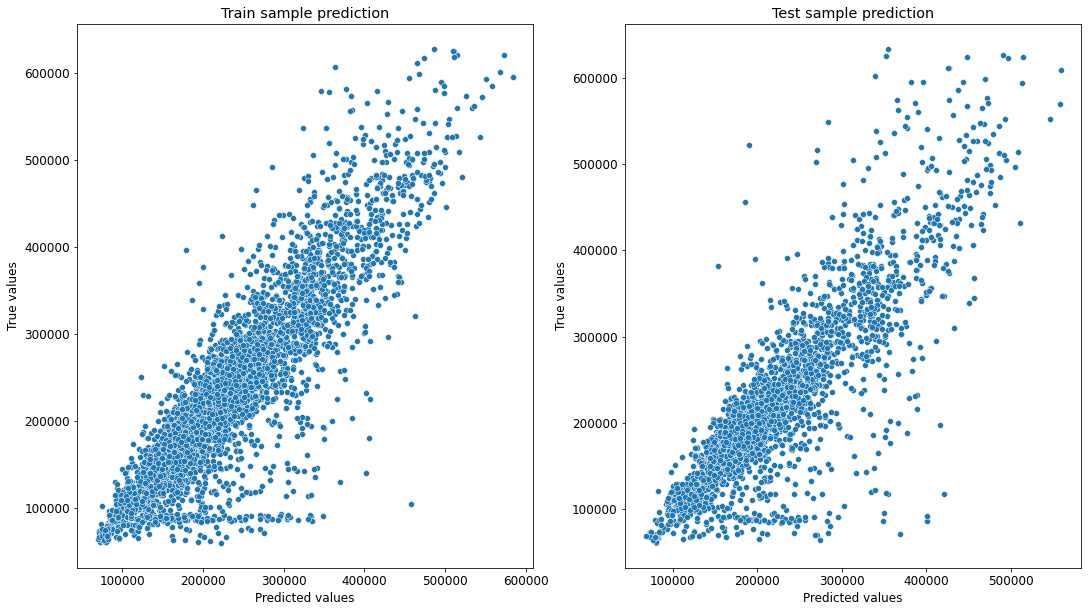

In [72]:
evaluate_preds(y_train, y_pred_train, y_test, y_pred)

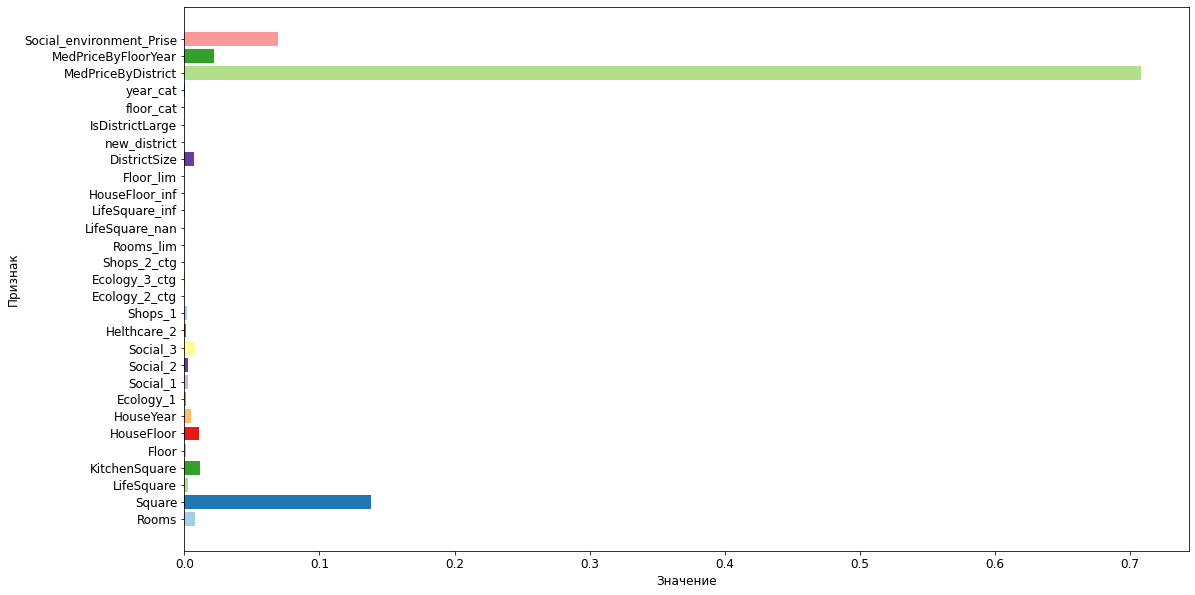

In [73]:
plt.figure(figsize=(18,10))
plt.barh(range(X.shape[1]), gbtree.feature_importances_, 
         align = 'center', color = sns.color_palette("Paired"))
plt.yticks(np.arange(X.shape[1]), feature_names)
plt.xlabel('Значение')
plt.ylabel('Признак')
plt.show()

### Линейная регрессия

In [74]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [75]:
y_pred = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

sc = r2_score(y_test, y_pred)
sc1 = r2_score(y_train, y_pred_train)
print('r2_scr_test = ', sc, '\nr2_scr_train = ', 
      sc1)

r2_scr_test =  0.6954230745277816 
r2_scr_train =  0.7003110174912535


Train R2:	0.7
Test R2:	0.695


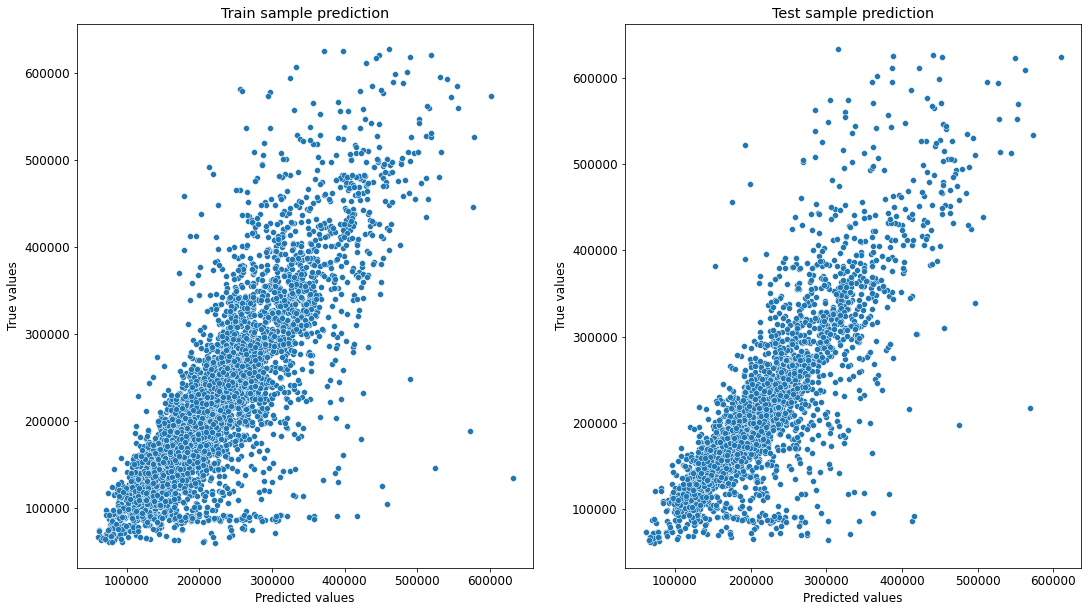

In [76]:
evaluate_preds(y_train, y_pred_train, y_test, y_pred)

## <span style="color:brown"> Применение модели на тестовых данных </span>

In [77]:
DATA_SUBMIT_PATH = './data/real-estate-price-prediction-moscow/sample_submission.csv'

In [78]:
submit = pd.read_csv(DATA_SUBMIT_PATH)

In [79]:
predictions = rftree.predict(df_test)

In [80]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,167108.456058
1,5925,121870.918068
2,960,139058.669234
3,3848,149411.964663
4,746,177929.037300


In [81]:
submit.to_csv('rf_submit.csv', index=False)